In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

columns = ['sentiment', 'tweets']

# Read the dataset with specified column names
df_train = pd.read_csv("/content/drive/MyDrive/training.csv", header=None, names=columns)

# Display the first few rows of the dataframe
df_train.head()

,sentiment,tweets
1,0,is so sad for my APL frie...
2,0,I missed the New Moon trail...
3,1,omg its already 7:30 :O
4,0,.. Omgaga. Im sooo im gunna CRy. I'...
5,0,i think mi bf is cheating on me!!! ...


# Preprocessing

In [4]:
df = df_train

In [5]:
df['sentiment'].value_counts()

0    387
1    179
Name: sentiment, dtype: int64

<Axes: xlabel='sentiment', ylabel='Count'>

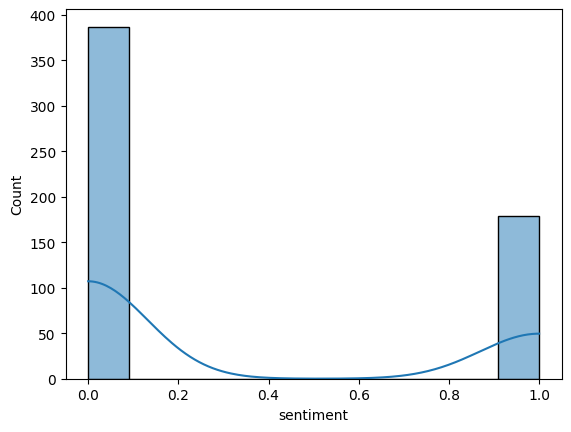

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['sentiment'],kde=True)

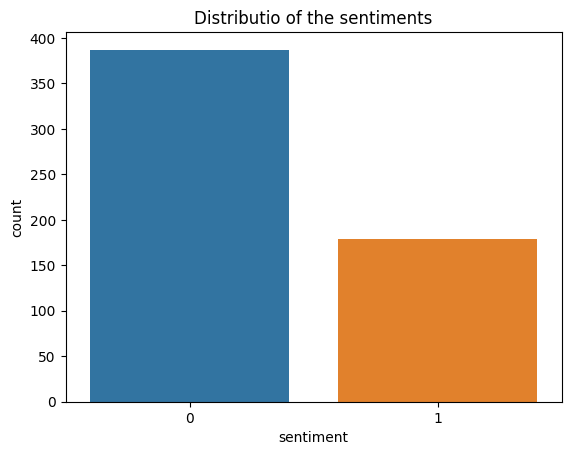

In [7]:
sns.countplot(data=df,x='sentiment')
plt.title('Distributio of the sentiments')
plt.show()

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()
corpus = df['tweets'].tolist()
print(len(corpus))
print(corpus[0])

566
                     is so sad for my APL friend.............


In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
final_corpus = []
final_corpus_joined = []
for i in df.index:
    text = re.sub('[^a-zA-Z]', ' ', df['tweets'][i])
    text = text.lower()
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text=re.sub("(\\d|\\W)+"," ",text)
    text = text.split()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text  if not word in stuff_to_be_removed]
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

In [12]:
data_cleaned = pd.DataFrame()
data_cleaned["text"] = final_corpus_joined
data_cleaned["sentiment"] = df["sentiment"].values

In [13]:
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = df['sentiment'].values
data_eda.head()

,text,sentiment
0,"[sad, apl, friend]",0
1,"[missed, new, moon, trailer]",0
2,"[omg, already]",1
3,"[omgaga, im, sooo, im, gunna, cry, dentist, si...",0
4,"[think, mi, bf, cheating]",0


# Decision Tree

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
xt = tfidf.fit_transform(data_cleaned['text'])
y = data_cleaned['sentiment']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xt,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42,
                                                    )

In [16]:
from sklearn.tree import DecisionTreeClassifier
# Train a Decision Tree model for feature selection
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [17]:
from sklearn.feature_selection import SelectFromModel
# Get feature importance scores
feature_importances = dt_classifier.feature_importances_

# Select the most important features
sfm = SelectFromModel(dt_classifier, threshold='mean')
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

In [18]:
# Access the selected features and their indices
selected_feature_indices = sfm.get_support(indices=True)

# Print the selected feature indices
print("Selected Feature Indices:", selected_feature_indices)

# Access the selected features in the training and testing sets
X_train_selected_features = X_train[:, selected_feature_indices]
X_test_selected_features = X_test[:, selected_feature_indices]

Selected Feature Indices: [  15   27   32   38   67   85   93   96  121  142  160  161  169  228
  229  243  286  315  316  419  449  471  496  535  547  558  577  690
  700  704  720  778  779  790  802  810  923  932  978  988  992 1007
 1021 1026 1034 1077 1094 1107 1120 1135 1143 1189 1226 1265 1281 1297
 1314 1323 1337 1369 1392 1468 1493 1532 1577 1588 1611 1618 1628 1631
 1636 1647 1679 1680 1681 1687 1693 1694 1738 1739 1793 1828 1835 1859
 1869 1878 1883 1932 1938 1943]


# RNN

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, SpatialDropout1D, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

max_features = 5000
embed_dim = 128
lstm_out = 128

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data_cleaned['text'].values)
X = tokenizer.texts_to_sequences(data_cleaned['text'].values)
X = pad_sequences(X)

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Y = pd.get_dummies(data_cleaned['sentiment']).values
# Use stratified sampling for train-test split to ensure balanced classes
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y, test_size=0.33, random_state=42, stratify=Y)

batch_size = 32
model.fit(X_train2, Y_train2, epochs=20, batch_size=batch_size, verbose=2, validation_split=0.2)

# Evaluate on the test set
score, acc = model.evaluate(X_test2, Y_test2, verbose=2, batch_size=batch_size)
print("Test Score: %.2f" % (score))
print("Test Accuracy: %.2f" % (acc))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 24, 128)           640000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 24, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 771842 (2.94 MB)
Trainable params: 771842 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
10/10 - 7s - loss: 0.6591 - accuracy: 0.6403 - val_loss: 0.6042 - va

# **Hybrid Model**

In [30]:
last_lstm_layer = model.get_layer('lstm_1')
output_size_of_lstm = last_lstm_layer.output_shape[-1]

In [36]:
from keras.models import Model
from keras.layers import Input, concatenate, Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split

input_dt = Input(shape=(X_train_selected_features.shape[1],))
input_lstm = Input(shape=(X_train2.shape[1],))

# Define Decision Tree branch
dt_branch = Dense(32, activation='relu')(input_dt)

# Define LSTM branch
lstm_branch = Embedding(max_features, embed_dim, input_length=X_train2.shape[1])(input_lstm)
lstm_branch = SpatialDropout1D(0.4)(lstm_branch)
lstm_branch = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)(lstm_branch)

# Concatenate both branches
merged = concatenate([dt_branch, lstm_branch])

# Additional Dense layer for combining features
combined = Dense(32, activation='relu')(merged)

# Output layer
output_layer = Dense(2, activation='softmax')(combined)

# Create the hybrid model
hybrid_model = Model(inputs=[input_dt, input_lstm], outputs=output_layer)

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(hybrid_model.summary())


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 24)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 24, 128)              640000    ['input_15[0][0]']            
                                                                                                  
 input_14 (InputLayer)       [(None, 90)]                 0         []                            
                                                                                                  
 spatial_dropout1d_2 (Spati  (None, 24, 128)              0         ['embedding_2[0][0]']         
 alDropout1D)                                                                               

In [53]:
from sklearn.model_selection import train_test_split

X_train_dt, X_test_dt, X_train_lstm, X_test_lstm, Y_train, Y_test = train_test_split(
    X_train_selected_features, X_train2, Y_train2, test_size=0.33, random_state=42
)



In [54]:
# Train the hybrid model
hybrid_model.fit([X_train_dt, X_train_lstm], Y_train, epochs=20, batch_size=batch_size, validation_split=0.2)

# Evaluate on the test set
score, acc = hybrid_model.evaluate([X_test_dt, X_test_lstm], Y_test, verbose=2, batch_size=batch_size)


Epoch 1/20
7/7 [==============================] - 8s 266ms/step - loss: 0.6886 - accuracy: 0.5495 - val_loss: 0.6574 - val_accuracy: 0.7059
Epoch 2/20
7/7 [==============================] - 1s 100ms/step - loss: 0.6286 - accuracy: 0.6931 - val_loss: 0.6327 - val_accuracy: 0.7059
Epoch 3/20
7/7 [==============================] - 1s 86ms/step - loss: 0.6053 - accuracy: 0.6931 - val_loss: 0.6171 - val_accuracy: 0.7059
Epoch 4/20
7/7 [==============================] - 1s 91ms/step - loss: 0.5980 - accuracy: 0.6931 - val_loss: 0.6151 - val_accuracy: 0.7059
Epoch 5/20
7/7 [==============================] - 1s 86ms/step - loss: 0.5654 - accuracy: 0.6931 - val_loss: 0.6195 - val_accuracy: 0.7059
Epoch 6/20
7/7 [==============================] - 1s 91ms/step - loss: 0.5368 - accuracy: 0.7079 - val_loss: 0.6161 - val_accuracy: 0.7059
Epoch 7/20
7/7 [==============================] - 1s 83ms/step - loss: 0.4775 - accuracy: 0.7624 - val_loss: 0.6259 - val_accuracy: 0.7059
Epoch 8/20
7/7 [=========